## Running decoding with `pylabianca`
This notebook offers a relatively short overview of the `pylabianca` package.
It is not meant to be a comprehensive tutorial, but rather a quick overview of
some of the functionality.

In [23]:
import os
import os.path as op

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylabianca as pln

# temp for tests:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read and epoch data
We first do some of the steps discussed in `intro_overview.ipynb` tutorial. Take a look there for explanation of the code below if you don't find it sufficiently clear:

In [3]:
data_dir = r'C:\Users\Ola Kołodziej\Dropbox\Sarenka\PROJECTS\pylabianca\labianca_data\sub-U10_task-superdual'
spike_data_dir = op.join(data_dir, r'osorted\mixed\5')

spk = pln.io.read_osort(spike_data_dir, waveform=True, format='standard')
events = pln.io.read_events_neuralynx(data_dir, format='mne')

# removing units
min_spikes = 250
sel = spk.n_spikes() >= min_spikes
spk.pick_cells(sel)

# epoching
event_id = [110, 111, 112]
last_part_start = np.where(events[:, -1] == 152)[0][-1]
use_events = events[:last_part_start]
spk_epochs = spk.epoch(use_events, event_id, tmin=-0.5, tmax=2.)

# adding metadata
is_img = np.in1d(use_events[:, -1], event_id)
image_id = use_events[is_img, -1] - 110
spk_epochs.metadata = pd.DataFrame({'image': image_id})

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.76it/s]


## Add brain region information
We also add information about brain region that given unit was recorded from:

In [5]:
channel_info = pd.read_excel(op.join(data_dir, 'sub-U10_channels.xlsx'))
pln.io.add_region_from_channel_ranges(
    spk_epochs, channel_info, source_column='area',
    target_column='region', channel_column='channel'
)

# we now have 'region' column in the cellinfo:
spk_epochs.cellinfo.head()

c:\src\pylabianca\pylabianca\io.py:666: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'LHIP' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  spk.cellinfo.loc[cell_msk, target_column] = region


,channel,cluster,alignment,threshold,region
0,A153,2024,mixed,5.0,LHIP
1,A153,2226,mixed,5.0,LHIP
2,A153,2238,mixed,5.0,LHIP
3,A153,2280,mixed,5.0,LHIP
4,A153,2306,mixed,5.0,LHIP


## Compute firing rate and run decoding

We compute firing rate separately for hippocampus and amygdala units, but grouping units from left and right of each of these two regions together:

In [11]:
frate = dict()
for sel_region in ['HIP', 'AMY']:
    both_regions = ['L' + sel_region, 'R' + sel_region]
    spk_sel = spk_epochs.copy().pick_cells(query=f'region in {both_regions}')
    frate[sel_region] = spk_sel.spike_density(fwhm=0.35)

Let's run decoding for "HIP" cells only first. We use `pln.decoding.frate_to_sklearn` to easily transform the data to scikit-learn-friendy format. We specify what we want to classify (`target` argument) - image id, and specify decimation to reduce the number of time samples (`decim=10` for 10-times reduction in number of time samples):

In [16]:
X, y, time = pln.decoding.frate_to_sklearn(frate['HIP'], target='image', decim=10)

we now have 10 times less samples in temporal dimension 

In [17]:
print('original number of time samples:', frate['HIP'].time.shape[0])
print('number of time samples in `X`:', time.shape[0])

original number of time samples: 805
number of time samples in `X`: 81


In [19]:
# let's run decoding
scores = pln.decoding.run_decoding(X, y, n_jobs=4)

The output is an array of scores (accuracy be default) of `n_folds x n_samples` shape:

In [20]:
scores.shape

(6, 81)

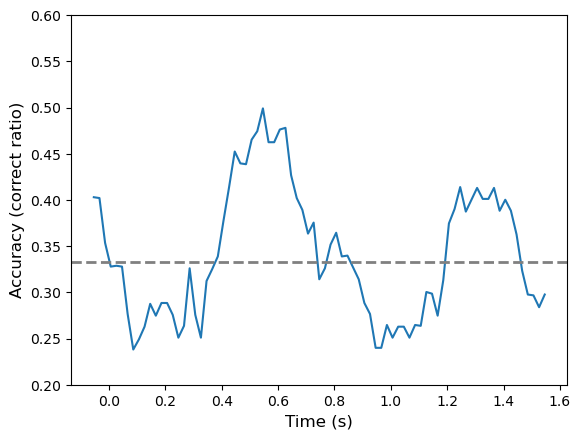

In [33]:
def format_axis(ax):
    random_performance = 1 / 3
    ax.axhline(random_performance, lw=2, color='gray', ls='--')
    
    ax.set_ylim(0.2, 0.6)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Accuracy (correct ratio)', fontsize=12)

lines = plt.plot(time, scores.mean(axis=0))
format_axis(lines[0].axes)

We see that around 450 - 650 ms poststimulus image identity can be decoded with higher than chance accuracy.  
To say whether this difference is significant we would have to run a permutation control for example. We do it later in this example, but now let's run decoding for amygdala too and compare both decoding traces:

In [ ]:
X, y, time = pln.decoding.frate_to_sklearn(
    frate['AMY'], target='image', decim=10)
scores2 = pln.decoding.run_decoding(X, y, n_jobs=4)

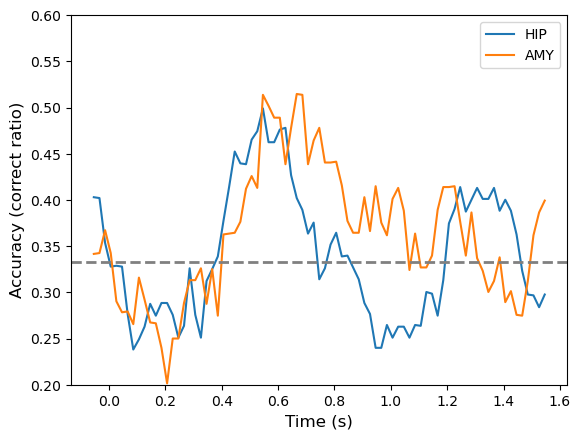

In [34]:
ax = plt.plot(time, scores.mean(axis=0), label='HIP')[0].axes
plt.plot(time, scores2.mean(axis=0), label='AMY')

format_axis(ax)
plt.legend()

We see that can decode image information both from hippocampus and amygdala units in a similar time window. Note that this effect may be due to just a few image selective cells present in both populations of neurons (also see the `intro_overview.ipynb` notebook where we look at units with good image selectivity).  

## Using maxCorr
We can compre the performance for amygdala units, when we switch from the default support vector classifier to MaxCorr:

In [45]:
mx_corr = pln.decoding.maxCorrClassifier()
scores2_mxc = pln.decoding.run_decoding(X, y, n_jobs=4, clf=mx_corr)

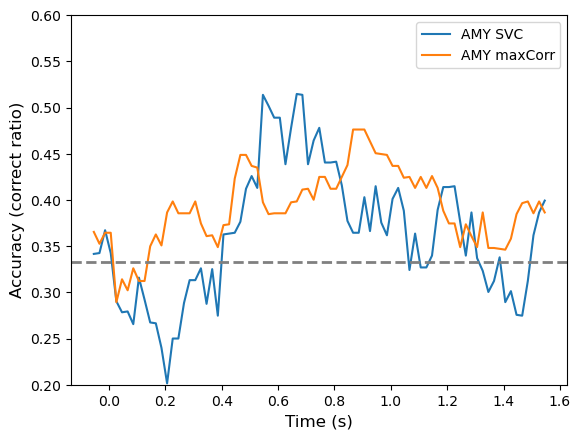

In [46]:
ax = plt.plot(time, scores2.mean(axis=0), label='AMY SVC')[0].axes
plt.plot(time, scores2_mxc.mean(axis=0), label='AMY maxCorr')

format_axis(ax)
plt.legend()

Especially in the timerange where SVC has the highest accuracy, maxCorr does worse (although it seems to do better in 0.8 - 1.2 s time window).

## Time generalization decoding
Before we perform the time-consuming permutation control let's take a look at the time-generalization for amygdala cells, this may take a few seconds:

In [35]:
scores_timegen = pln.decoding.run_decoding(
    X, y, n_jobs=6, time_generalization=True)

The outcome array is `n_folds x n_samples x n_samples`:

In [36]:
scores_timegen.shape

(6, 81, 81)

Let's plot the outcome using `borsar`, a dependency of `pylabianca`:

Text(0, 0.5, 'Training time (s)')

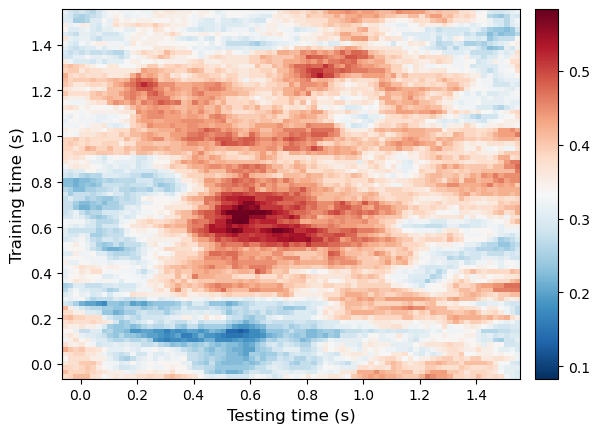

In [43]:
import borsar

random_performance = 1 / 3
image_ax, cbar_ax = borsar.viz.heatmap(
    scores_timegen.mean(axis=0), x_axis=time, y_axis=time,
    vmin=random_performance - 0.25, vmax=random_performance + 0.25
)
image_ax.set_xlabel('Testing time (s)', fontsize=12)
image_ax.set_ylabel('Training time (s)', fontsize=12)

the neural pattern that allows to discriminate the images is generalizible to some extent. 

## Permutation control

This may take a few minutes...

In [47]:
from tqdm import tqdm

y_perm = y.copy()
scores_perm = list()
for _ in tqdm(range(100)):
    np.random.shuffle(y_perm)
    perm_score = pln.decoding.run_decoding(X, y_perm, n_jobs=8)
    scores_perm.append(perm_score.mean(axis=0))
scores_perm = np.stack(scores_perm, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


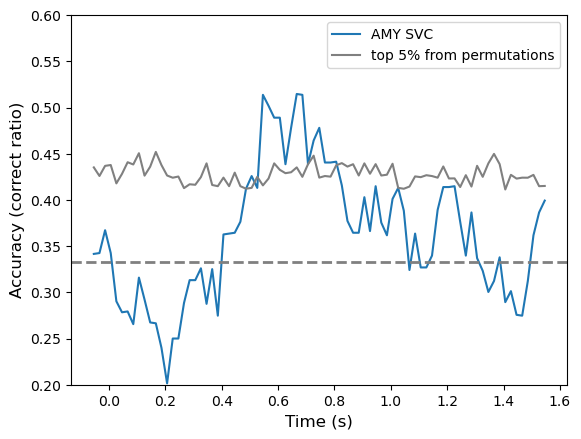

In [49]:
perm_top = np.percentile(scores_perm, 95, axis=0)

ax = plt.plot(time, scores2.mean(axis=0), label='AMY SVC')[0].axes
plt.plot(time, perm_top, color='gray', label='top 5% from permutations')

format_axis(ax)
plt.legend()

Duging the 0.5 - 0.8 s time window the decoding performance is higher than chance (at least using this one-sided permutation test).